Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 14       |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 19976    |
|    time_elapsed     | 0        |
|    total_timesteps  | 20       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 14       |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 19988    |
|    time_elapsed     | 0        |
|    total_timesteps  | 40       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 14     

C:\Users\yongl\AppData\Local\Temp\ipykernel_7896\2587548724.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", self.num_objects + 1)  # Get a colormap with enough colors


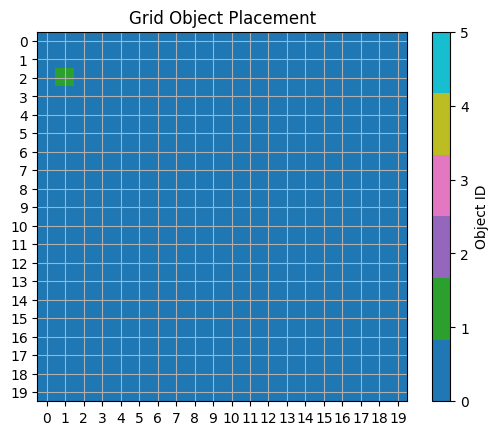

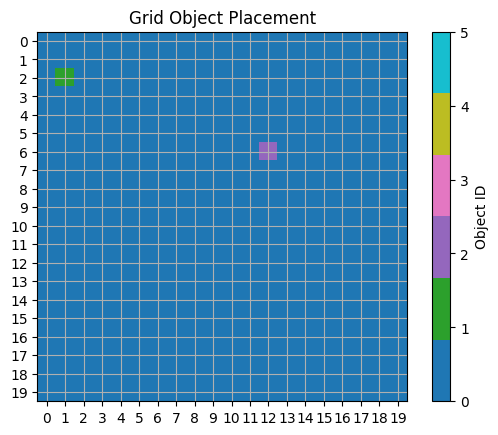

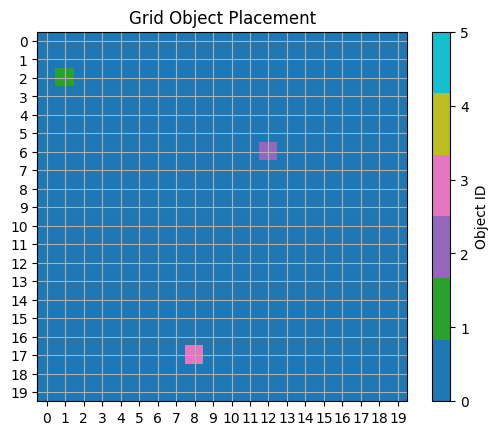

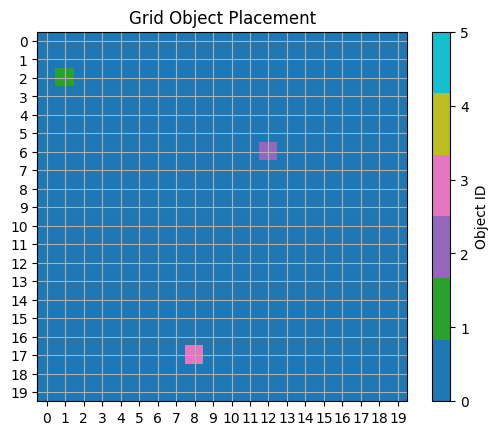

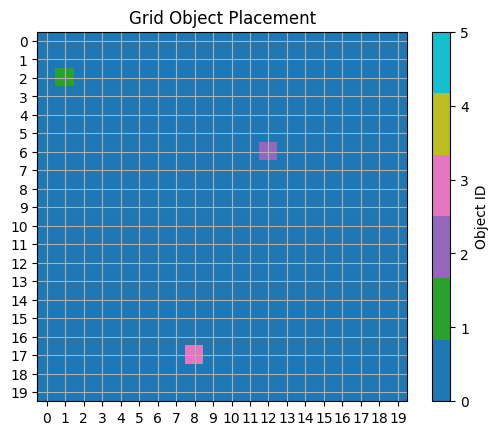

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from gymnasium import spaces, Env

class CustomGridEnv(Env):
    """Custom Grid environment that follows Gym API (inherits from gym.Env)."""
    
    def __init__(self, grid_size, num_objects):
        super(CustomGridEnv, self).__init__()
        self.grid_size = grid_size
        self.num_objects = num_objects
        
        # Action space: Choose a position on the grid (discrete)
        self.action_space = spaces.Discrete(grid_size * grid_size)
        
        # Observation space: Flattened grid with 0 (empty) and unique values for each object
        self.observation_space = spaces.Box(low=0, high=self.num_objects, shape=(grid_size * grid_size,), dtype=np.int32)
        
        self.grid = np.zeros((grid_size, grid_size), dtype=int)  # Initialize grid
        self.seed_val = None  # To store seed if provided

    def reset(self, seed=None):
        """Resets the environment and returns the initial observation."""
        # Optional: Apply the seed for reproducibility
        if seed is not None:
            self.seed_val = seed
            np.random.seed(seed)
        
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self.current_object = 0  # Track how many objects have been placed
        self.placed_positions = set()  # Keep track of placed positions
        return self.grid.flatten(), {}

    def step(self, action):
        """Places an object at the given position."""
        # Decode action (row, col)
        row = action // self.grid_size
        col = action % self.grid_size

        # If the position is already occupied, return a negative reward
        if (row, col) in self.placed_positions:
            return self.grid.flatten(), -1, False, False, {}

        # Place the object with a unique number (object id)
        self.grid[row, col] = self.current_object + 1
        self.placed_positions.add((row, col))

        self.current_object += 1

        # Check if all objects are placed
        done = self.current_object == self.num_objects

        # Calculate reward
        reward = 1 if not done else 10  # Reward for placing objects, bonus on completion

        # `terminated` is True if the task is done
        terminated = done
        # `truncated` is False as we are not using time limits or external stopping
        truncated = False

        return self.grid.flatten(), reward, terminated, truncated, {}

    def render(self):
        """Render the grid using matplotlib with unique colors for each object."""
        cmap = plt.cm.get_cmap("tab10", self.num_objects + 1)  # Get a colormap with enough colors
        plt.imshow(self.grid, cmap=cmap, vmin=0, vmax=self.num_objects)
        plt.title("Grid Object Placement")
        plt.xticks(np.arange(self.grid_size))
        plt.yticks(np.arange(self.grid_size))
        plt.colorbar(ticks=np.arange(self.num_objects + 1), label="Object ID")
        plt.grid(True)
        plt.show()



total_grid_size = 100
total_plant_species = 100
# Train the DQN model with gym-compatible environment
def train_model():
    # Create an instance of the custom environment
    grid_size = total_grid_size
    num_objects = total_plant_species
    env = CustomGridEnv(grid_size, num_objects)

    # Initialize DQN model
    model = DQN("MlpPolicy", env, verbose=1)

    # Train the model
    model.learn(total_timesteps=10000)

    # Save the trained model
    model.save("dqn_grid_object_placement")

    print("Training completed and model saved!")

def visualize_model():
    # Load the trained model
    model = DQN.load("dqn_grid_object_placement")

    # Create an instance of the custom environment
    grid_size = total_grid_size
    num_objects = total_plant_species
    env = CustomGridEnv(grid_size, num_objects)

    obs, _ = env.reset()

    for _ in range(num_objects):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)

        # Render the current state of the grid
        env.render()

        if done:
            break

if __name__ == "__main__":
    # Uncomment the following line to train the model
    train_model()

    # Visualize how the trained model places objects on the grid
    visualize_model()


# Second Try

## Grid Generation Layer
The first code here is used to generate the numpy 100 by 100 in order to have a playable area

This can be replaced by an OCR/CV layer in the future

C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\3378427772.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 4)  # 4 colors: 0 (empty), 1 (road), 2 (walkway), 3 (building)


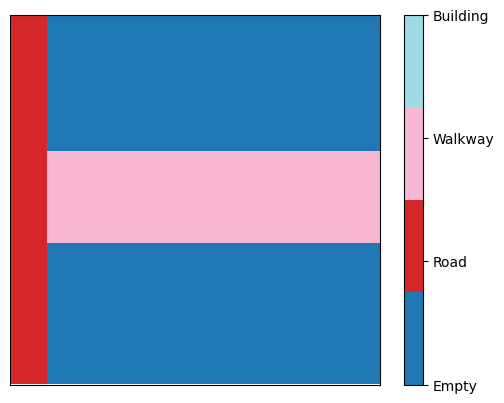

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [144]:
import numpy as np
import matplotlib.pyplot as plt

def create_grid(grid_size, road_list, walkway_list, building_list):
    # Initialize the grid with zeros (empty spaces)
    grid = np.zeros((grid_size, grid_size), dtype=np.uint8)

    # Add roads (label them as '1')
    for (x, y) in road_list:
        if 0 <= x < grid_size and 0 <= y < grid_size:  # Ensure the coordinates are within bounds
            grid[x, y] = 1  # Road
    
    # Add walkways (label them as '2')
    for (x, y) in walkway_list:
        if 0 <= x < grid_size and 0 <= y < grid_size:  # Ensure the coordinates are within bounds
            grid[x, y] = 2  # Walkway

    # Add buildings (label them as '3')
    for (x, y) in building_list:
        if 0 <= x < grid_size and 0 <= y < grid_size:  # Ensure the coordinates are within bounds
            grid[x, y] = 3  # Building

    return grid

def render_grid(grid):
    # Render the grid using matplotlib
    cmap = plt.cm.get_cmap("tab20", 4)  # 4 colors: 0 (empty), 1 (road), 2 (walkway), 3 (building)
    plt.imshow(grid, cmap=cmap, vmin=0, vmax=3)
    plt.xticks([])  # Remove x-axis labels
    plt.yticks([])  # Remove y-axis labels
    
    # Add custom color bar with labels for each feature
    cbar = plt.colorbar(ticks=[0, 1, 2, 3])  # Custom ticks for each feature
    cbar.ax.set_yticklabels(['Empty', 'Road', 'Walkway', 'Building'])  # Set the labels for the ticks
    
    plt.grid(False)  # Remove grid lines
    plt.show()

# Set the grid size to 100x100
grid_size = 100
road_width = 3

# Define lists of coordinates for roads, walkways, and buildings
road_list = [(y, x) for y in range(0, grid_size) for x in range(0,  10)]  # Vertical road with width
walkway_list = [(y, x) for y in range(3 * grid_size//8, 5 * grid_size//8) for x in range(10,  grid_size)]  # Vertical road with width

building_list = []  # Sample building coordinates

# Create the grid with roads, walkways, and buildings
grid = create_grid(grid_size, road_list, walkway_list, building_list)

# Render the grid
render_grid(grid)
print(grid)


## Labelling the area based on the proximity on the grid

In [145]:
import numpy as np

def pythagorean_distance(x1, y1, x2, y2):
    # Calculate the Euclidean distance between two points (x1, y1) and (x2, y2)
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def label_empty_tiles(grid, threshold):
    grid_size = grid.shape[0]

    # Extract coordinates for each feature from the grid
    road_coords = np.argwhere(grid == 1)  # Find all positions labeled as '1' (roads)
    walkway_coords = np.argwhere(grid == 2)  # Find all positions labeled as '2' (walkways)
    building_coords = np.argwhere(grid == 3)  # Find all positions labeled as '3' (buildings)

    # Traverse all tiles in the grid
    for i in range(grid_size):
        for j in range(grid_size):
            # If the tile is empty (0)
            if grid[i, j] == 0:
                min_dist_to_road = min([pythagorean_distance(i, j, x, y) for x, y in road_coords], default=np.inf)
                min_dist_to_walkway = min([pythagorean_distance(i, j, x, y) for x, y in walkway_coords], default=np.inf)
                min_dist_to_building = min([pythagorean_distance(i, j, x, y) for x, y in building_coords], default=np.inf)

                # Find the minimum distance to any feature
                min_dist = min(min_dist_to_road, min_dist_to_walkway, min_dist_to_building)

                # Label based on closest feature if within threshold
                if min_dist <= threshold:
                    if min_dist == min_dist_to_road:
                        grid[i, j] = 4  # Label as 'near road'
                    elif min_dist == min_dist_to_walkway:
                        grid[i, j] = 5  # Label as 'near walkway'
                    elif min_dist == min_dist_to_building:
                        grid[i, j] = 6  # Label as 'near building'

    return grid


threshold = 10  # Set a distance threshold
labeled_grid = label_empty_tiles(grid, threshold)

C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\2689720629.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 7)  # 7 colors: 0 (empty), 1 (road), 2 (walkway), 3 (building), 4, 5, 6


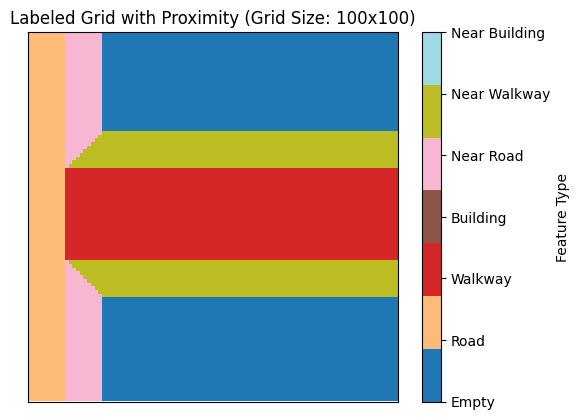

In [146]:
import matplotlib.pyplot as plt

def render_grid(grid):
    # Define a colormap with 7 distinct colors
    cmap = plt.cm.get_cmap("tab20", 7)  # 7 colors: 0 (empty), 1 (road), 2 (walkway), 3 (building), 4, 5, 6

    # Render the grid using matplotlib
    plt.imshow(grid, cmap=cmap, vmin=0, vmax=6)
    plt.title(f"Labeled Grid with Proximity (Grid Size: {grid.shape[0]}x{grid.shape[1]})")
    
    # Remove axis labels
    plt.xticks([])  # Remove x-axis labels
    plt.yticks([])  # Remove y-axis labels
    
    # Add custom color bar with labels for each feature
    cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4, 5, 6])  # Custom ticks for each feature
    cbar.ax.set_yticklabels(['Empty', 'Road', 'Walkway', 'Building', 'Near Road', 'Near Walkway', 'Near Building'])  # Set the labels for the ticks
    cbar.set_label("Feature Type")  # Set label for the color bar

    plt.grid(False)  # Remove grid lines
    plt.show()

# Assuming the labeled grid has been created using label_empty_tiles
render_grid(labeled_grid)



C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\4208670479.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 2)  # Use 2 colors for feature and black


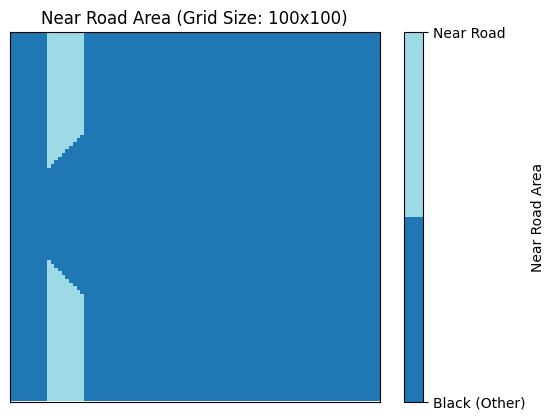

C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\4208670479.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 2)  # Use 2 colors for feature and black


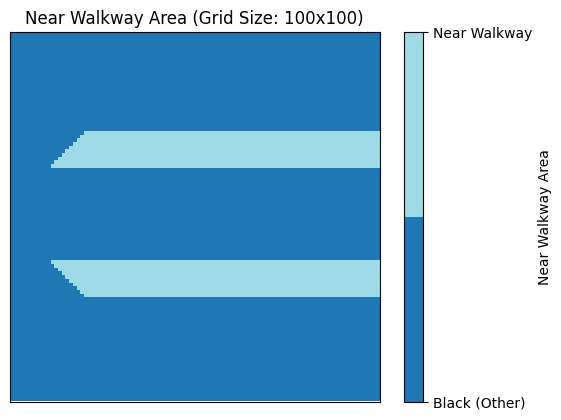

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [147]:
import numpy as np
import matplotlib.pyplot as plt

def create_specific_area_grid(grid, feature_label, color_label=-1):
    # Create a copy of the grid
    specific_grid = np.full(grid.shape, color_label)  # Initialize with the color_label (black)
    
    # Set the feature_label area (e.g., near road, near walkway, etc.)
    specific_grid[grid == feature_label] = feature_label  # Keep the feature label, set others to color_label
    
    return specific_grid

def render_specific_area(grid, feature_label, label_name):
    specific_grid = create_specific_area_grid(grid, feature_label)

    # Define a colormap with two colors: feature and black (other areas)
    cmap = plt.cm.get_cmap("tab20", 2)  # Use 2 colors for feature and black

    # Render the specific grid using matplotlib
    plt.imshow(specific_grid, cmap=cmap, vmin=-1, vmax=feature_label)
    plt.title(f"{label_name} Area (Grid Size: {specific_grid.shape[0]}x{specific_grid.shape[1]})")
    
    # Remove axis labels
    plt.xticks([])  # Remove x-axis labels
    plt.yticks([])  # Remove y-axis labels
    
    # Add custom color bar with labels for the feature
    cbar = plt.colorbar(ticks=[-1, feature_label])  # Custom ticks for black and the feature
    cbar.ax.set_yticklabels(['Black (Other)', label_name])  # Set the labels for the ticks
    cbar.set_label(f"{label_name} Area")  # Set label for the color bar

    plt.grid(False)  # Remove grid lines
    plt.show()
    return grid
# Assuming the labeled grid has been created using label_empty_tiles
# Render grids for specific feature areas (near road, near walkway, near building)

# Near Road Area
render_specific_area(labeled_grid, feature_label=4, label_name="Near Road")

# Near Walkway Area
render_specific_area(labeled_grid, feature_label=5, label_name="Near Walkway")

# Near Building Area
# render_specific_area(labeled_grid, feature_label=6, label_name="Near Building")


C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\4208670479.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 2)  # Use 2 colors for feature and black


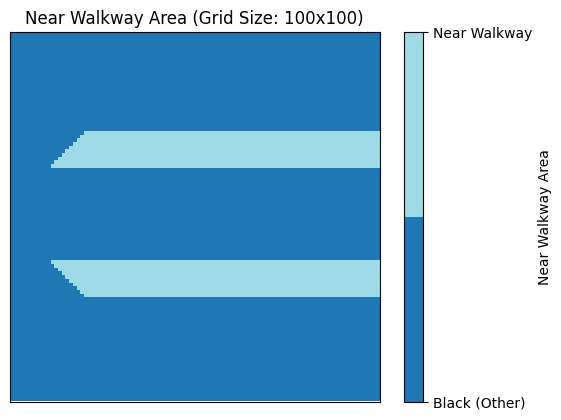

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [148]:
render_specific_area(labeled_grid, feature_label=5, label_name="Near Walkway")


## Step 3, generating within the sectioned areas

Takes too long and would require too many steps in order to result in actual training/good model


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\240582626.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 7)  # 7 colors for the various feature labels


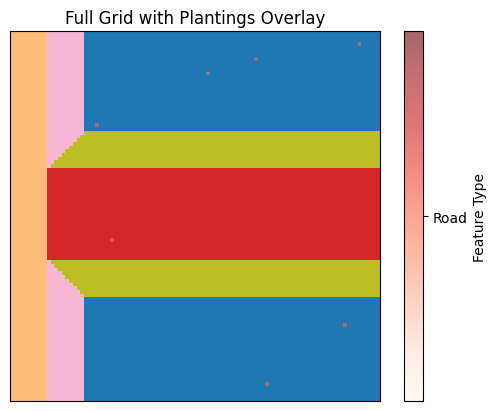

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from gymnasium import Env, spaces

class GridPlantingEnv(Env):
    """Custom Grid environment for reinforcement learning where the agent must plant in specified areas."""
    
    def __init__(self, grid, target_area_label):
        super(GridPlantingEnv, self).__init__()
        
        self.grid_size = grid.shape[0]
        self.grid = grid
        self.target_area_label = target_area_label  # The label for the area where planting is allowed
        
        # Action space: Choose a position on the grid (discrete)
        self.action_space = spaces.Discrete(self.grid_size * self.grid_size)
        
        # Observation space: Flattened grid with current state
        self.observation_space = spaces.Box(low=0, high=6, shape=(self.grid_size * self.grid_size,), dtype=np.uint8)
        
        # Initial empty planting grid
        self.planting_grid = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)

    def reset(self, seed=None, options=None):
        """Resets the environment and returns the initial observation."""
        super().reset(seed=seed)  # Ensure seed is passed correctly to allow reproducibility
        self.planting_grid = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)  # Reset planting grid
        return self.grid.flatten(), {}

    def step(self, action):
        """Takes an action (planting at a specific location) and calculates the reward."""
        row = action // self.grid_size
        col = action % self.grid_size

        # Check if the square is already planted
        if self.planting_grid[row, col] != 0:
            return self.grid.flatten(), -10, False, False, {}  # Penalize for replanting on the same spot

        # Plant at the chosen square
        self.planting_grid[row, col] = 1

        # Reward based on whether the planting is in the correct area
        if self.grid[row, col] == self.target_area_label:
            reward = 10  # Reward for planting in the correct area
        else:
            reward = -5  # Penalize for planting outside the target area

        # The episode continues until all squares are planted or terminated by the agent
        done = np.all(self.planting_grid != 0)  # Done when all tiles are planted
        return self.grid.flatten(), reward, done, False, {}

    def render(self):
        """Render the grid with current plantings."""
        cmap = plt.cm.get_cmap("tab20", 2)  # Use 2 colors for unplanted and planted areas
        plt.imshow(self.planting_grid, cmap=cmap, vmin=0, vmax=1)
        plt.title(f"Planting Grid (Grid Size: {self.grid_size}x{self.grid_size})")
        plt.xticks([])  # Remove x-axis labels
        plt.yticks([])  # Remove y-axis labels
        plt.grid(False)
        plt.show()

def create_specific_area_grid(grid, feature_label):
    """Create a grid with only the specific area (e.g., near road)."""
    specific_grid = np.zeros_like(grid)
    specific_grid[grid == feature_label] = feature_label  # Keep only the target area
    return specific_grid

def render_full_grid_with_plantings(grid, planting_grid):
    """Render the full grid with different areas and plantings overlayed."""
    cmap = plt.cm.get_cmap("tab20", 7)  # 7 colors for the various feature labels
    plt.imshow(grid, cmap=cmap, vmin=0, vmax=6)
    plt.title("Full Grid with Plantings Overlay")
    
    # Overlay the plantings in red
    plt.imshow(np.ma.masked_where(planting_grid == 0, planting_grid), cmap="Reds", alpha=0.6)
    
    plt.xticks([])
    plt.yticks([])
    
    # Color bar for the grid
    cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4, 5, 6])
    cbar.ax.set_yticklabels(['Empty', 'Road', 'Walkway', 'Building', 'Near Road', 'Near Walkway', 'Near Building'])
    cbar.set_label("Feature Type")
    
    plt.grid(False)
    plt.show()

# Example usage:
# Assuming `labeled_grid` is the grid generated from previous steps (with specific area labels)

# Create a grid with only the "near road" areas (label 4)
near_road_grid = create_specific_area_grid(labeled_grid, feature_label=4)

# Create an environment where the agent is rewarded for planting near roads (label 4)
env = GridPlantingEnv(near_road_grid, target_area_label=4)

# Define the RL model
model = DQN("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=100000)

# Test the model and visualize
obs, _ = env.reset()
actions = 100
for x in range(actions):  # Take 100 actions
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    
    # Render the full grid with plantings on the last step
    if x == (actions - 1):
        render_full_grid_with_plantings(labeled_grid, env.planting_grid)
    
    if done:
        break


## Trying using 3x + 1

Essentially me trying to use a formula to generate possible plant placement

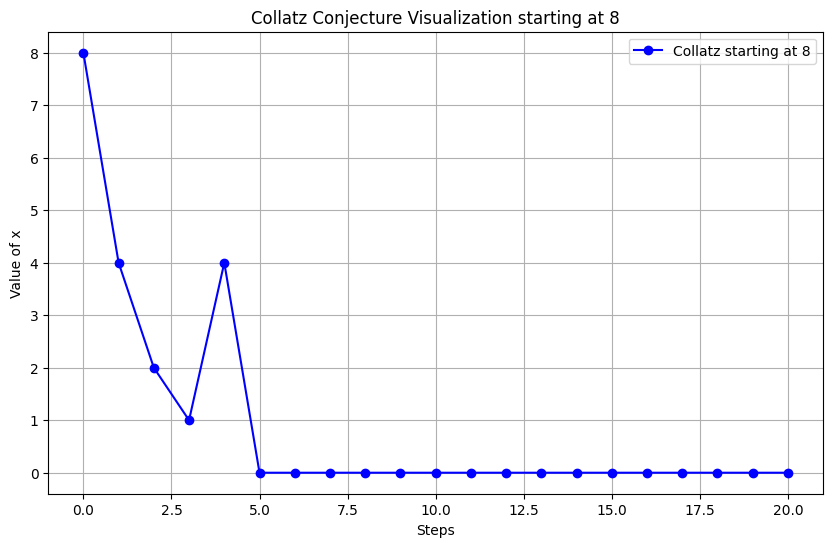

In [39]:
import matplotlib.pyplot as plt

def collatz_visualize(start_x, steps):
    x = start_x
    coords = [(0, x)]  # Store coordinates (step, value of x)
    
    for step in range(1, steps + 1):
        if x % 2 == 0:
            x = x // 2  # If even, continue straight
            coords.append((step, x))
        else:
            # If odd, create a branch by applying 3x + 1
            branch_x = 3 * x + 1
            coords.append((step, branch_x))  # New branch
            x = x // 2  # Continue with half of the original x

    # Extract x and y values from coordinates for plotting
    steps, values = zip(*coords)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, marker='o', color='b', label=f"Collatz starting at {start_x}")
    
    plt.title(f"Collatz Conjecture Visualization starting at {start_x}")
    plt.xlabel("Steps")
    plt.ylabel("Value of x")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
collatz_visualize(start_x=8, steps=20)


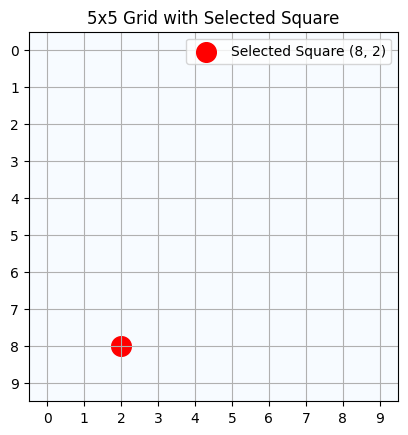

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import random

def create_grid(size=10):
    """Create a size x size numpy grid."""
    return np.zeros((size, size), dtype=int)

def select_square(grid, row, col):
    """Select a single square from the grid and return the selected position."""
    # Check if the row and col are within the bounds of the grid
    if 0 <= row < grid.shape[0] and 0 <= col < grid.shape[1]:
        return row, col
    else:
        raise ValueError(f"Row {row} or Column {col} is out of bounds for grid size {grid.shape[0]}.")

def visualize_grid(grid, selected_position):
    """Visualize the grid and highlight the selected square."""
    plt.imshow(grid, cmap="Blues", vmin=0, vmax=1)  # Visualize the grid with a color map
    
    # Highlight the selected square with a red marker
    row, col = selected_position
    plt.scatter(col, row, color='red', s=200, label=f'Selected Square ({row}, {col})')
    
    plt.title("5x5 Grid with Selected Square")
    plt.xticks(np.arange(grid.shape[1]))  # Set x-axis tick labels
    plt.yticks(np.arange(grid.shape[0]))  # Set y-axis tick labels
    plt.grid(True)
    plt.legend()
    
    plt.show()

# Create a 5x5 grid
grid = create_grid()

# Example: Select a single square at row 2, column 3
selected_position = select_square(grid, random.randrange(10), random.randrange(10))

# Visualize the grid and the selected square
visualize_grid(grid, selected_position)


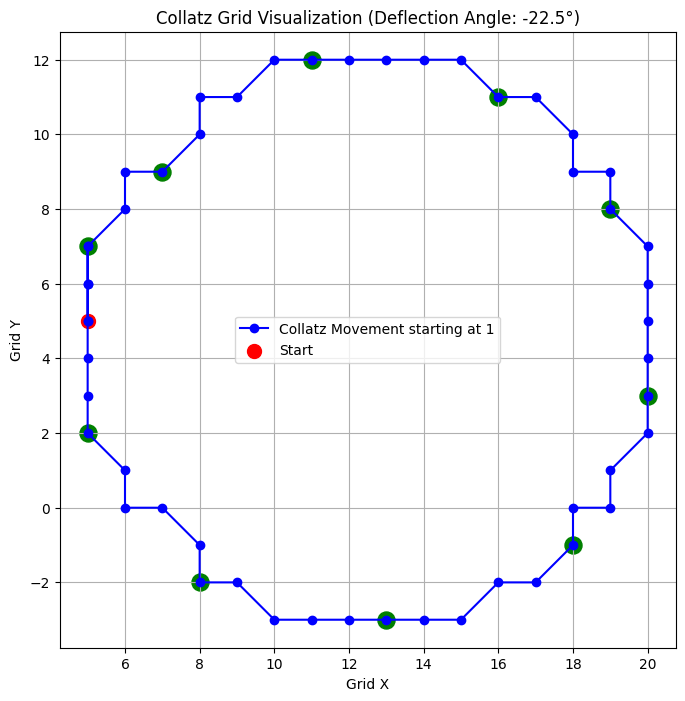

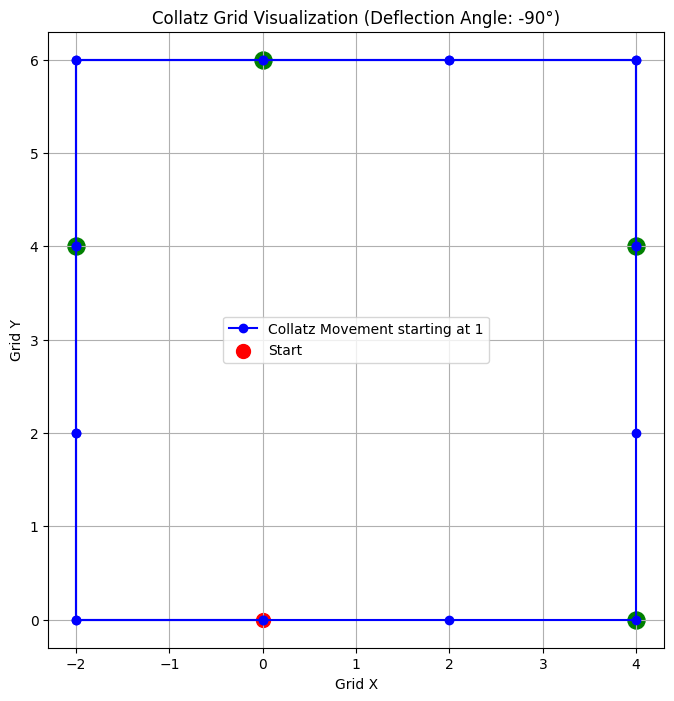

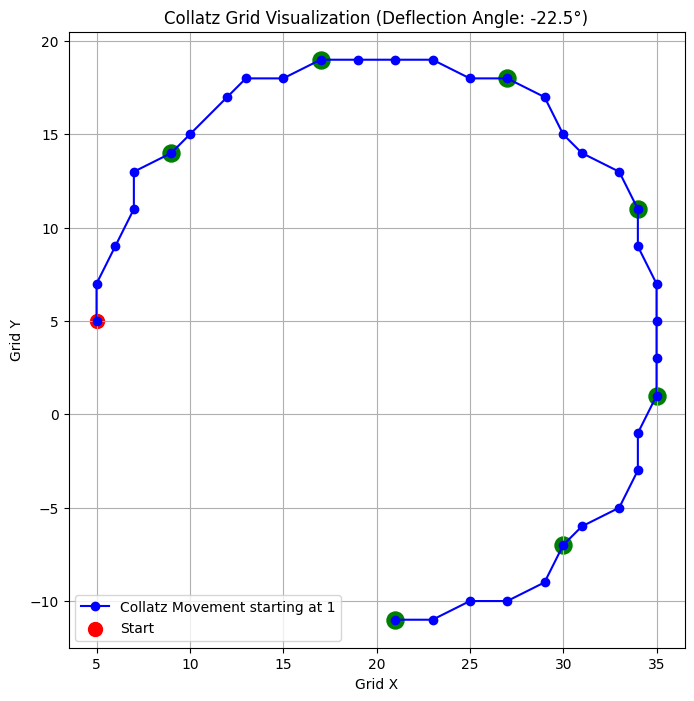

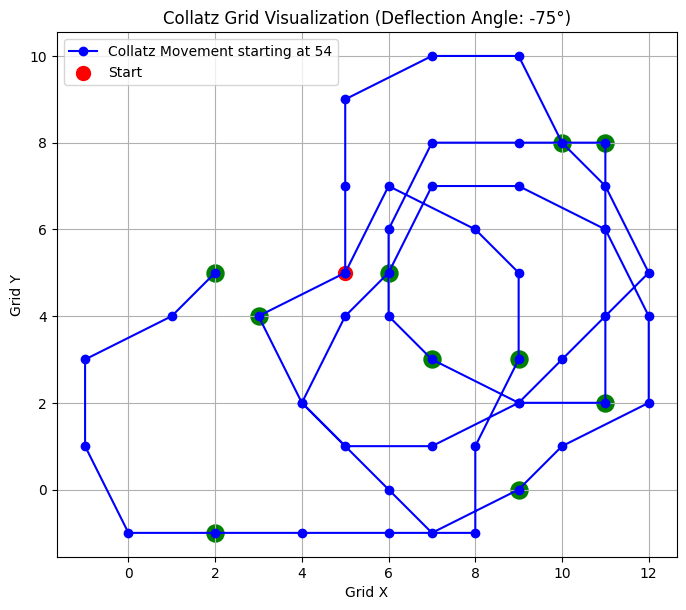

[(10, 8),
 (7, 3),
 (11, 8),
 (9, 0),
 (6, 5),
 (11, 2),
 (3, 4),
 (9, 3),
 (2, -1),
 (2, 5)]

In [255]:
import matplotlib.pyplot as plt
import numpy as np

def rotate_vector(vector, angle):
    """Rotate the vector by the specified angle."""
    angle_rad = np.radians(angle)  # Convert angle to radians
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    return rotation_matrix @ vector  # Apply the rotation matrix to the vector

def collatz_grid_visualize(start_x, steps, start_tile=(5, 5), start_angle=0, odd_angle_deflection=45, distance=1, highlight_every_n=5, visualize=True):
    """Visualize the 3x + 1 rule on a grid, deflecting by a given angle when odd.
       The number of steps is determined by steps * highlight_every_n.
       Returns the list of positions and the highlighted nodes as a result."""
    
    x = start_x
    coords = [start_tile]  # Store coordinates for the grid movements
    current_pos = np.array(start_tile)  # Start from the given tile
    
    # Initialize direction as a unit vector in the given angle (0 degrees is upwards)
    current_dir = np.array([0, 1])  # 0 degrees corresponds to moving "up" in the y-axis

    # Rotate the initial vector based on the provided starting angle
    current_dir = rotate_vector(current_dir, start_angle)

    # List to store highlighted nodes
    highlighted_coords = []

    total_steps = steps * highlight_every_n  # Total steps now determined by the product

    for step in range(total_steps):
        if x == 0:
            print(f"Terminating: Reached value 0 at step {step}")
            break  # Terminate the process if x becomes 0

        # Move in the current direction scaled by the distance
        current_pos = current_pos + current_dir * distance
        # Store the rounded position for plotting and list
        rounded_pos = tuple(round(coord) for coord in current_pos)
        coords.append(rounded_pos)  # Store the new rounded position

        # Highlight every nth node (starting after the first move)
        if (step + 1) % highlight_every_n == 0:
            highlighted_coords.append(rounded_pos)

        if x % 2 != 0:
            # Rotate the direction by the specified deflection angle if odd
            current_dir = rotate_vector(current_dir, odd_angle_deflection)

        # Calculate next number in the Collatz sequence
        if x % 2 == 0:
            x = x // 2  # If even, divide by 2
        else:
            x = 3 * x + 1  # If odd, apply 3x + 1

    # If visualize is enabled, plot the grid and highlighted nodes
    if visualize:
        # Extract x and y values for plotting (already rounded)
        x_vals, y_vals = zip(*coords)

        # Plotting the grid and the movements
        plt.figure(figsize=(8, 8))
        plt.plot(x_vals, y_vals, marker='o', color='b', label=f"Collatz Movement starting at {start_x}")
        
        # Highlight the starting point
        plt.scatter([start_tile[0]], [start_tile[1]], color='red', s=100, label="Start")
        
        # Highlight every nth node (using the same rounded coordinates)
        for i, (x_val, y_val) in enumerate(zip(x_vals, y_vals)):
            if i % highlight_every_n == 0 and i != 0:  # Make sure not to highlight the 0th index if unwanted
                plt.scatter(x_val, y_val, color='green', s=150, label=f"Node {i}" if i == 0 else "")  # First one gets a label

        plt.title(f"Collatz Grid Visualization (Deflection Angle: {odd_angle_deflection}°)")
        plt.xlabel("Grid X")
        plt.ylabel("Grid Y")
        plt.grid(True)
        plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')  # Ensure square aspect ratio for the grid
        plt.show()

    # Return the list of highlighted nodes
    return highlighted_coords






# Example usage:
collatz_grid_visualize(start_x=1, steps=10, start_tile=(5, 5), start_angle=0, odd_angle_deflection=-22.5, distance=1, visualize=True) #Circle
# collatz_grid_visualize(start_x=1, steps=25, start_tile=(5, 5), start_angle=0, odd_angle_deflection=-45, distance=2, visualize=False) #less circle
# In order for higher definition, you can shrink the distance, decrease the angle and increase the number of steps

# |
collatz_grid_visualize(start_x=1, steps=4, start_tile=(0, 0), start_angle=90, odd_angle_deflection=-90, distance=2) #Square

collatz_grid_visualize(start_x=1, steps=7, start_tile=(5, 5), start_angle=0, odd_angle_deflection=-22.5, distance=2) #Weird Curve away
# collatz_grid_visualize(start_x=7, steps=25, start_tile=(5, 5), start_angle=0, odd_angle_deflection=-22.5, distance=2) #Weird Curve away

collatz_grid_visualize(start_x=54, steps=10, start_tile=(5, 5), start_angle=0, odd_angle_deflection=-75, distance=2) #Weird Curve away
# collatz_grid_visualize(start_x=101, steps=25, start_tile=(5, 5), start_angle=0, odd_angle_deflection=-22.5, distance=2) #Weird Curve away








# Possible inputs for RnL,
# Start_X, 1 (1, 7, 54, 101)
# Steps, 1 - 10
# start_tile, fixed based on the environment (baesd on environment)
# Start_angle (Fixed based on the direction given by the seed location chooser)
# Odd angle deflection (0, 5, 10, 22.5, 45)
# distance (let's fix at 5 for trees)



## Step 5 Trying to use the formula in the plant placement RL

C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\4208670479.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 2)  # Use 2 colors for feature and black


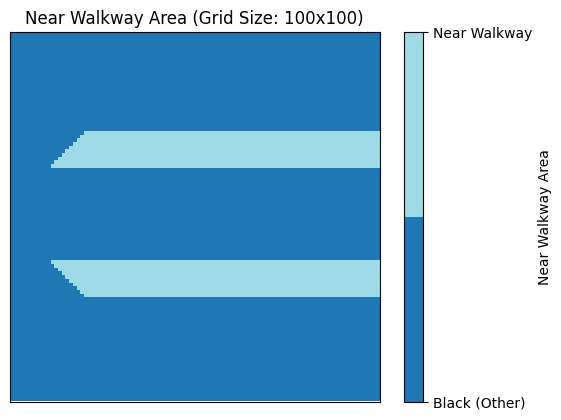

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [149]:
render_specific_area(labeled_grid, feature_label=5, label_name="Near Walkway")


C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\3012229466.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 2)  # Use 2 colors for feature and black


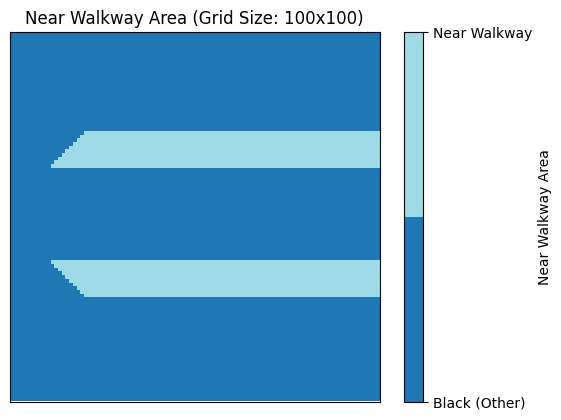

Distances from point (32, 20) to color change: [5, 4, 5, 79]


C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\3012229466.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 10)  # Use up to 10 colors to include the point


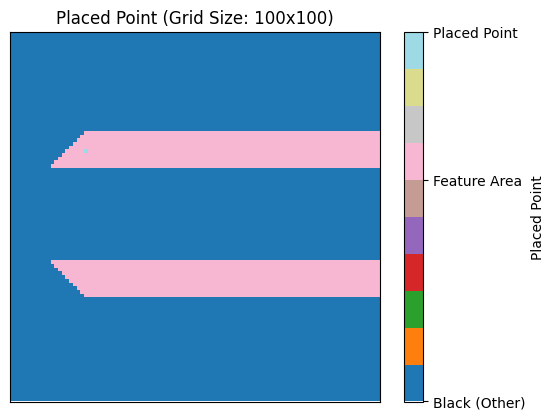

------------------------------
[5, 4, 5, 79]
0
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]
(32, 20)


In [200]:
import numpy as np
import matplotlib.pyplot as plt

def render_grid_with_point(grid, point, point_color=9, label_name="Placed Point"):
    """
    Renders the grid with a point placed in it.
    
    Parameters:
    - grid: The grid with the placed point
    - point: Tuple representing the point's (row, col) coordinates
    - point_color: The color of the point (default: 9)
    - label_name: Label name for the point
    """
    grid_with_point = place_point_on_grid(grid, point, point_color)
    
    # Define a colormap with enough colors to include the point
    cmap = plt.cm.get_cmap("tab20", 10)  # Use up to 10 colors to include the point
    
    # Render the grid with the placed point
    plt.imshow(grid_with_point, cmap=cmap, vmin=-1, vmax=9)
    plt.title(f"{label_name} (Grid Size: {grid_with_point.shape[0]}x{grid_with_point.shape[1]})")
    
    # Remove axis labels
    plt.xticks([])  # Remove x-axis labels
    plt.yticks([])  # Remove y-axis labels
    
    # Add a color bar with the placed point labeled
    cbar = plt.colorbar(ticks=[-1, 5, 9])  # Black, feature, and point colors
    cbar.ax.set_yticklabels(['Black (Other)', 'Feature Area', 'Placed Point'])  # Set custom labels
    cbar.set_label(f"{label_name}")
    
    plt.grid(False)  # Remove grid lines
    plt.show()
    return grid_with_point, point

def create_specific_area_grid(grid, feature_label, color_label=-1):
    # Create a copy of the grid
    specific_grid = np.full(grid.shape, color_label)  # Initialize with the color_label (black)
    
    # Set the feature_label area (e.g., near road, near walkway, etc.)
    specific_grid[grid == feature_label] = feature_label  # Keep the feature label, set others to color_label
    
    return specific_grid

def render_specific_area(grid, feature_label, label_name):
    specific_grid = create_specific_area_grid(grid, feature_label)

    # Define a colormap with two colors: feature and black (other areas)
    cmap = plt.cm.get_cmap("tab20", 2)  # Use 2 colors for feature and black

    # Render the specific grid using matplotlib
    plt.imshow(specific_grid, cmap=cmap, vmin=-1, vmax=feature_label)
    plt.title(f"{label_name} Area (Grid Size: {specific_grid.shape[0]}x{specific_grid.shape[1]})")
    
    # Remove axis labels
    plt.xticks([])  # Remove x-axis labels
    plt.yticks([])  # Remove y-axis labels
    
    # Add custom color bar with labels for the feature
    cbar = plt.colorbar(ticks=[-1, feature_label])  # Custom ticks for black and the feature
    cbar.ax.set_yticklabels(['Black (Other)', label_name])  # Set the labels for the ticks
    cbar.set_label(f"{label_name} Area")  # Set label for the color bar

    plt.grid(False)  # Remove grid lines
    plt.show()
    return specific_grid

def place_point_on_grid(grid, point, point_color=9):
    """
    Places a point of a new color on the specific grid at the given location.
    
    Parameters:
    - grid: The grid on which to place the point
    - point: Tuple representing the (row, col) of the point
    - point_color: The color of the point to place (default is 9 for white)
    """
    # Create a copy of the grid to avoid modifying the original one
    grid_with_point = np.copy(grid)
    
    row, col = point
    
    # Check if the point is within bounds
    if row < 0 or col < 0 or row >= grid.shape[0] or col >= grid.shape[1]:
        raise ValueError("Point is out of grid bounds.")
    
    # Place the point on the grid
    grid_with_point[row, col] = point_color
    
    return grid_with_point

def find_distance_and_max_angle(grid, point, initial_color):
    """
    Finds the distance from the point to the nearest change in color in all 4 directions.
    
    Parameters:
    - grid: The numpy grid with feature values
    - point: Tuple representing the starting point (row, col)
    - initial_color: The color of the feature area (e.g., 5 for pink area)
    
    Returns:
    - List of distances and the angle corresponding to the highest distance.
    """
    row, col = point
    directions = {
        "up": (-1, 0),
        "down": (1, 0),
        "left": (0, -1),
        "right": (0, 1)
    }
    
    angles = {
        "up": 90,
        "down": 270,
        "left": 180,
        "right": 0
    }
    
    results = {}
    distances = []  # List to store the distances

    for direction, (d_row, d_col) in directions.items():
        distance = 0
        current_row, current_col = row + d_row, col + d_col
        
        # Move in the direction until we reach a grid boundary or a change in value
        while 0 <= current_row < grid.shape[0] and 0 <= current_col < grid.shape[1]:
            if grid[current_row, current_col] != initial_color:
                results[direction] = {"distance": distance, "angle": angles[direction]}  # Log the distance and angle once we find a color change
                break
            
            distance += 1
            current_row += d_row
            current_col += d_col
        
        # If no valid transition is found, log the last counted distance and the angle
        if direction not in results:
            results[direction] = {"distance": distance, "angle": angles[direction]}
        
        # Store the distance
        distances.append(distance)

    # Find the maximum distance and its corresponding angle
    max_direction = max(results, key=lambda k: results[k]["distance"])
    max_angle = results[max_direction]["angle"]
    
    return distances, max_angle


specific_grid = render_specific_area(labeled_grid, feature_label=5, label_name="Near Walkway")

# Now, place a point in the area and visualize it
point_to_place = (32, 20)  # Example tuple to place the point
placed_grid = place_point_on_grid(specific_grid, point_to_place)

# Find distances to the nearest color change in all directions
distances_to_change, max_angle  = find_distance_and_max_angle(placed_grid, point_to_place, initial_color=5)
print(f"Distances from point {point_to_place} to color change: {distances_to_change}")

# Render the grid with the placed point
render_grid_with_point(specific_grid, point=point_to_place, point_color=9, label_name="Placed Point")


print('-' * 30)
print(distances_to_change)
print(max_angle)
print(placed_grid)
print(point_to_place)



In [195]:
def place_points_on_grid(grid, points, marker=9):
    """
    Places points from the given list on the grid with the specified marker.
    
    Parameters:
    - grid: The numpy grid to modify
    - points: List of tuples representing points to place the marker
    - marker: The value to place in the grid at each point (default: 9)
    
    Returns:
    - updated_grid: The grid with the points marked
    """
    updated_grid = np.copy(grid)
    
    for point in points:
        row, col = point
        if 0 <= row < updated_grid.shape[0] and 0 <= col < updated_grid.shape[1]:
            updated_grid[row, col] = marker
    
    return updated_grid

def render_grid_with_plants(grid, plant_marker=9):
    """
    Renders the grid with plants marked by the plant_marker.
    
    Parameters:
    - grid: The grid to render
    - plant_marker: The marker for plants (default: 9)
    """
    cmap = plt.cm.get_cmap("tab20", 10)  # Adjust the colormap to fit the range of markers
    plt.imshow(grid, cmap=cmap, vmin=-1, vmax=plant_marker)
    plt.title(f"Grid with Plants Placed (Marker: {plant_marker})")
    plt.xticks([])  # Remove x-axis labels
    plt.yticks([])  # Remove y-axis labels
    plt.grid(False)
    plt.colorbar()
    plt.show()


C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\3886916295.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 10)  # Adjust the colormap to fit the range of markers


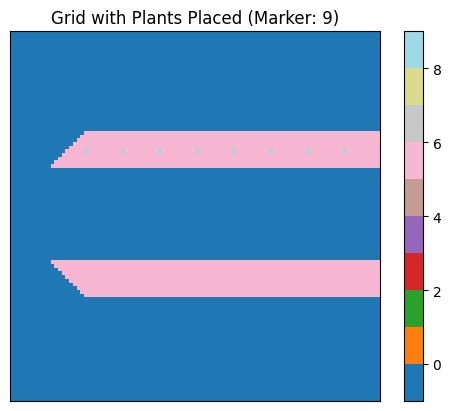

In [201]:
collatz_points = collatz_grid_visualize(
    start_x=1, 
    steps=40,  # Define how many steps you want in the sequence
    start_tile=point_to_place, 
    start_angle=max_angle, 
    odd_angle_deflection=0, 
    distance=2, 
    visualize=False  # Disable visualization for now
)

# Place the points on the grid with marker '9' for plants
planted_grid = place_points_on_grid(placed_grid, collatz_points, marker=9)

# Render the grid with the plants
render_grid_with_plants(planted_grid, plant_marker=9)

------------------------------
[5, 4, 5, 79]
0
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]
(32, 20)


C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\3886916295.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 10)  # Adjust the colormap to fit the range of markers


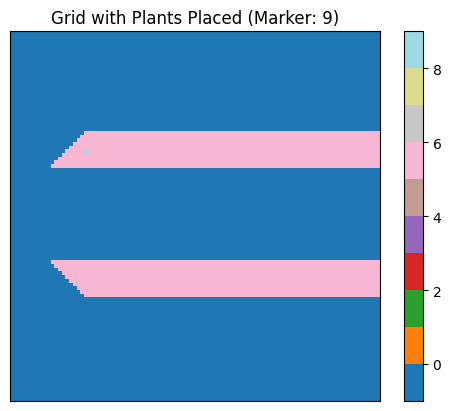

In [206]:
print('-' * 30)
print(point_to_place) # The location of the point
print(distances_to_change) # distance before the initial point is no longer in the area
print(max_angle) # The direction corresponding to the longest side
print(placed_grid) #The grid with only the unplantable area and desirable area and possible points

collatz_grid_visualize(1, 20, start_tile=(5, 5), start_angle=0, odd_angle_deflection=45, distance=1, highlight_every_n=5, visualize=True)
# Possible inputs
# Start_X, (1, 7, 54, 101)
# Steps, (10 - 50)
# start_tile, use point to place
# Start_angle, use max angle
# Odd angle deflection (0, 5, 10, 22.5, 45)
# distance, use 5



render_grid_with_plants(placed_grid, plant_marker=9)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1489 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 911          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0134755615 |
|    clip_fraction        | 0.127        |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.69        |
|    explained_variance   | 0.00484      |
|    learning_rate        | 0.0003       |
|    loss                 | 220          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00236     |
|    std

C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\120208910.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)  # Get a colormap with enough colors


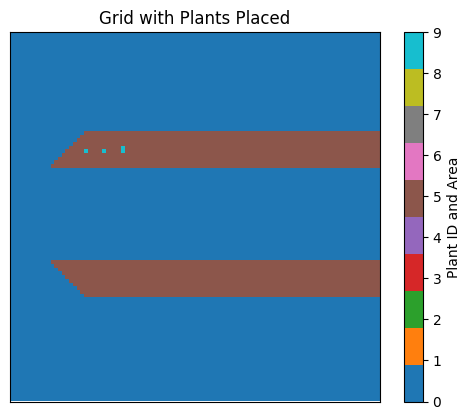

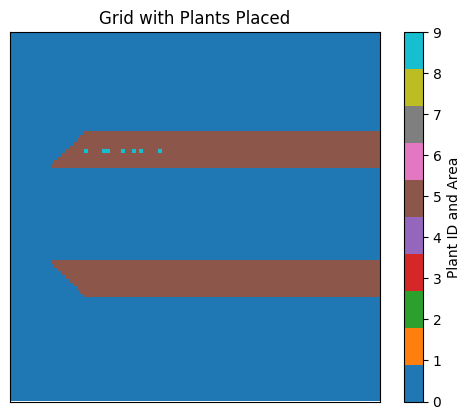

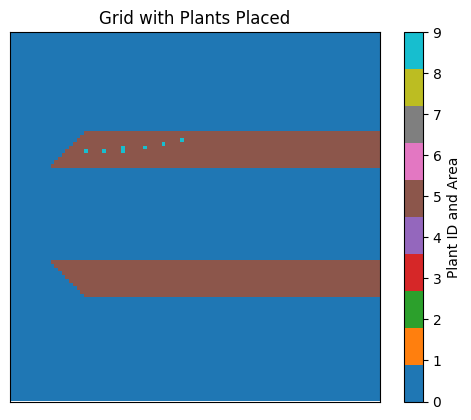

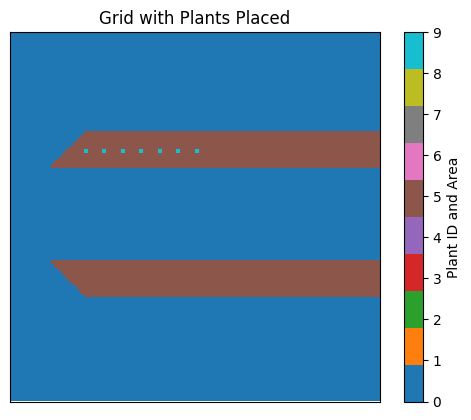

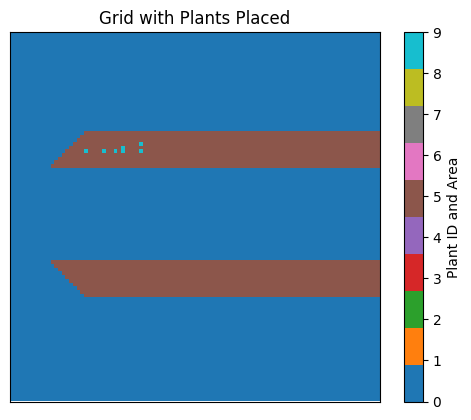

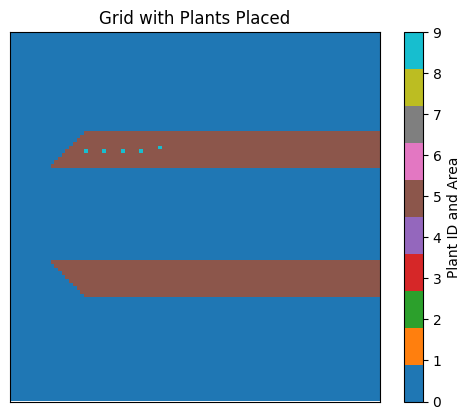

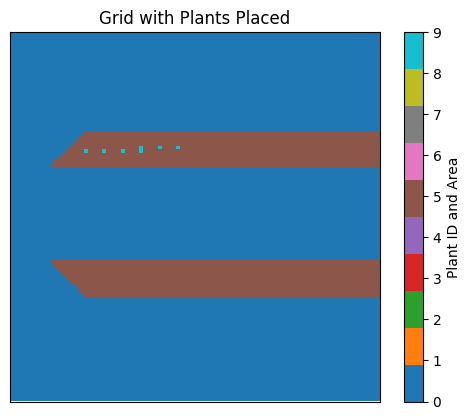

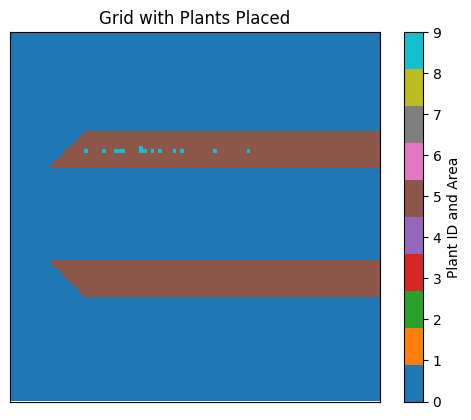

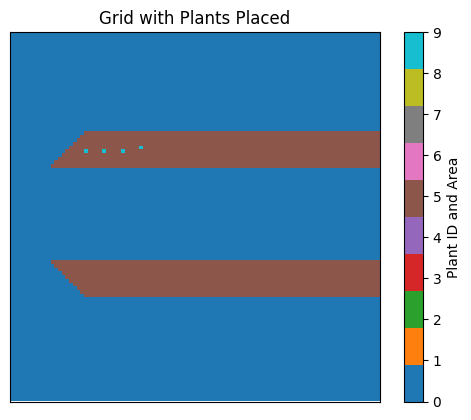

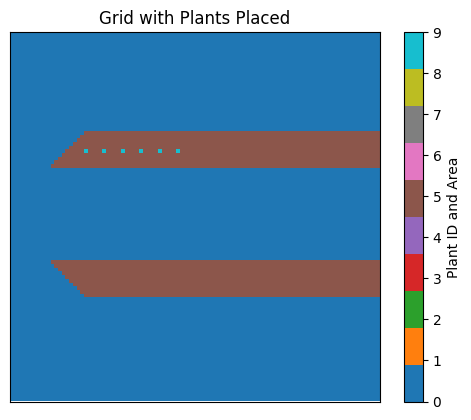

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from gymnasium import spaces, Env

class CustomGridEnv(Env):
    """Custom Grid environment with continuous action space for PPO."""
    
    def __init__(self, grid, point_to_place, distances_to_change, max_angle, placed_grid):
        super(CustomGridEnv, self).__init__()
        
        self.grid_size = grid.shape[0]
        self.num_objects = len(distances_to_change)  # The number of generated points
        
        self.grid = grid
        self.point_to_place = point_to_place
        self.distances_to_change = distances_to_change
        self.max_angle = max_angle
        self.placed_grid = placed_grid
        
        # Continuous action space: A combination of the inputs used in the function (Box space)
        self.action_space = spaces.Box(low=np.array([1, 2, 0, 1]), high=np.array([101, 10, 45, 5]), dtype=np.float32)
        
        # Observation space: The grid, flattened
        self.observation_space = spaces.Box(low=0, high=9, shape=(self.grid_size * self.grid_size,), dtype=np.float32)
        
        self.seed_val = None  # To store seed if provided

    def reset(self, seed=None):
        """Resets the environment and returns the initial observation."""
        # Optional: Apply the seed for reproducibility
        if seed is not None:
            self.seed_val = seed
            np.random.seed(seed)
        
        self.grid = np.copy(self.placed_grid)  # Reset to the base grid with unplantable areas
        self.current_object = 0  # Track how many objects have been placed
        self.placed_positions = set()  # Keep track of placed positions
        return self.grid.flatten(), {}

    def step(self, action):
        """Takes an action by modifying inputs to the Collatz function and evaluates the reward."""
        start_x, steps, odd_angle_deflection, distance = action
        
        # Use the collatz function to generate points
        collatz_points = collatz_grid_visualize(start_x, int(steps), start_tile=self.point_to_place, 
                                                start_angle=self.max_angle, odd_angle_deflection=odd_angle_deflection, 
                                                distance=distance, visualize=False)
        
        reward = 0
        
        # Check if generated points fall within the correct areas and reward/penalize
        for point in collatz_points:
            if (0 <= point[0] < self.grid_size and 0 <= point[1] < self.grid_size) and \
               (self.placed_grid[point[0], point[1]] == self.placed_grid[self.point_to_place[0] + 1, self.point_to_place[1]]):
                reward += 1  # Reward for planting correctly
                self.grid[point[0], point[1]] = 9  # Mark the plant on the grid
            else:
                reward -= 1  # Penalize for planting in the wrong area

        done = self.current_object == self.num_objects
        terminated = done
        truncated = False

        return self.grid.flatten(), reward, terminated, truncated, {}

    def render(self):
        """Render the grid using matplotlib with the plants."""
        cmap = plt.cm.get_cmap("tab10", 10)  # Get a colormap with enough colors
        plt.imshow(self.grid, cmap=cmap, vmin=0, vmax=9)
        plt.title("Grid with Plants Placed")
        plt.xticks([])  # Remove x-axis labels
        plt.yticks([])  # Remove y-axis labels
        plt.grid(False)
        plt.colorbar(label="Plant ID and Area")
        plt.show()


def train_model(grid, point_to_place, distances_to_change, max_angle, placed_grid):
    # Create an instance of the custom environment with all the required inputs
    env = CustomGridEnv(grid, point_to_place, distances_to_change, max_angle, placed_grid)

    # Initialize PPO model (supports continuous action spaces)
    model = PPO("MlpPolicy", env, verbose=1)

    # Train the model
    model.learn(total_timesteps=50000)

    # Save the trained model
    model.save("ppo_grid_plant_placement")

    print("Training completed and model saved!")


def visualize_model(grid, point_to_place, distances_to_change, max_angle, placed_grid):
    # Load the trained model
    model = PPO.load("ppo_grid_plant_placement")

    # Create an instance of the custom environment with all the required inputs
    env = CustomGridEnv(grid, point_to_place, distances_to_change, max_angle, placed_grid)

    obs, _ = env.reset()

    for x in range(env.num_objects):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)

        # Render the current state of the grid
        if (x == env.num_objects - 1):
            env.render()

        if done:
            break


# Example Usage:
# Assuming the grid, point_to_place, distances_to_change, max_angle, and placed_grid are defined
train_model(grid, point_to_place, distances_to_change, max_angle, placed_grid)

for i in range(10):
    visualize_model(grid, point_to_place, distances_to_change, max_angle, placed_grid)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1515 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 909         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010312209 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.66       |
|    explained_variance   | -0.00497    |
|    learning_rate        | 0.0003      |
|    loss                 | 243         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00234    |
|    std                

C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\1528842526.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)  # Get a colormap with enough colors


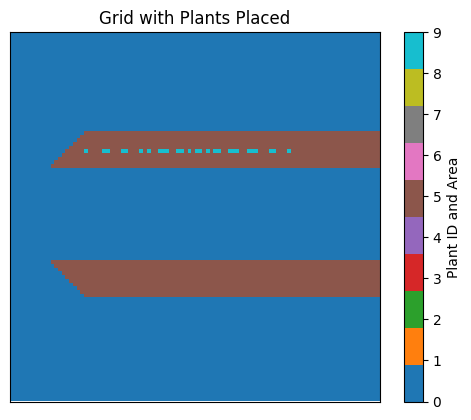

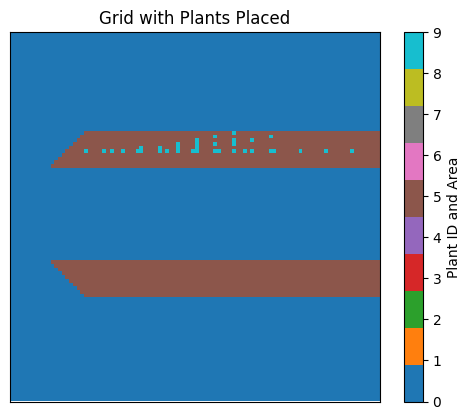

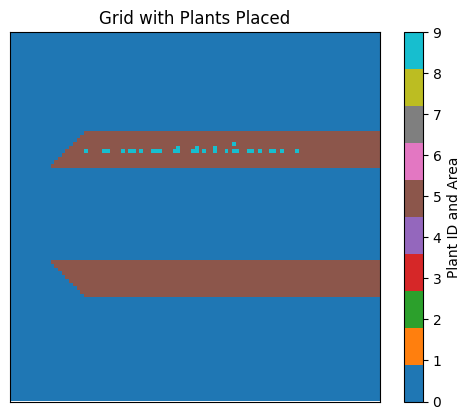

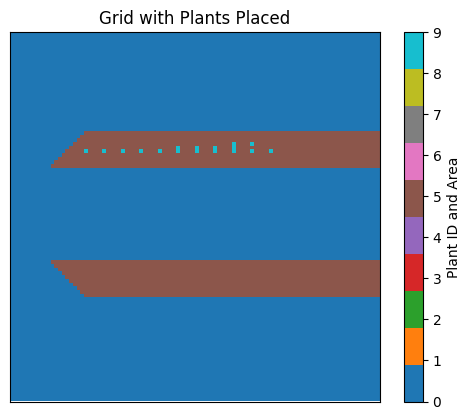

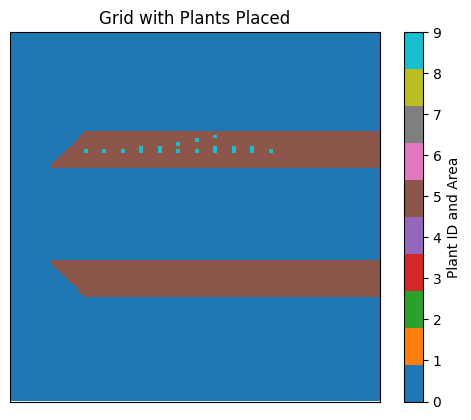

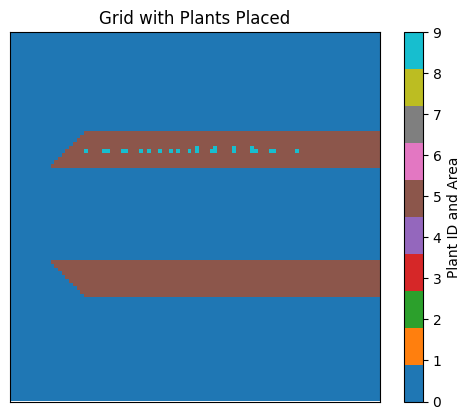

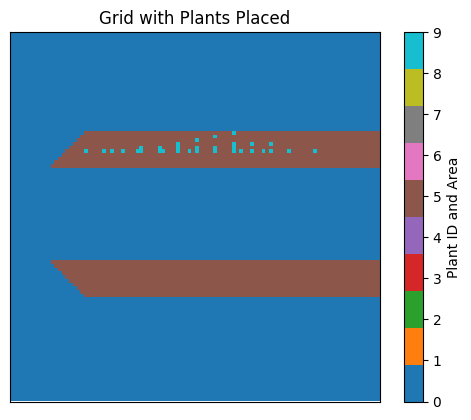

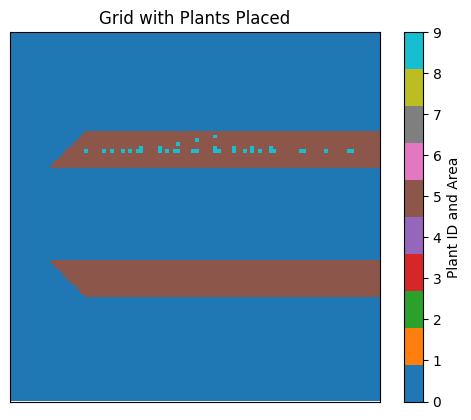

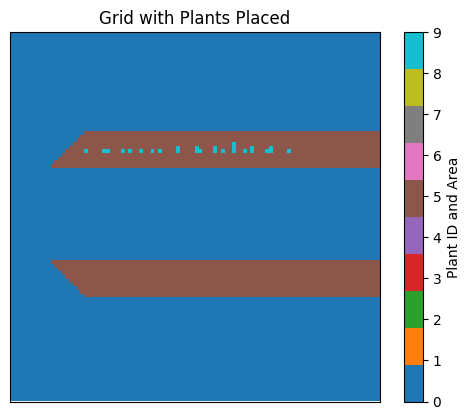

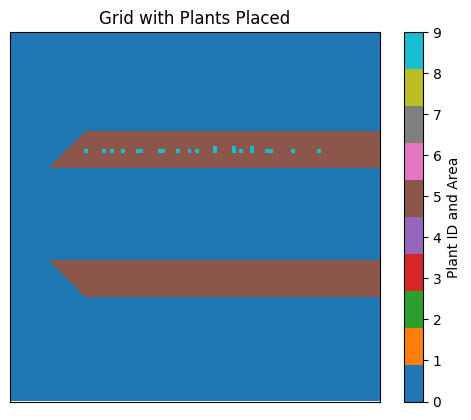

In [272]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from gymnasium import spaces, Env

class CustomGridEnv(Env):
    """Custom Grid environment with continuous action space for PPO."""
    
    def __init__(self, grid, point_to_place, max_angle, placed_grid):
        super(CustomGridEnv, self).__init__()
        
        self.grid_size = grid.shape[0]
        self.num_objects = 10  # Define the number of points to place based on your requirement
        
        self.grid = grid
        self.point_to_place = point_to_place
        self.max_angle = max_angle
        self.placed_grid = placed_grid
        
        # Continuous action space: A combination of the inputs used in the function (Box space)
        self.action_space = spaces.Box(low=np.array([1, 2, 0, 1]), high=np.array([101, 10, 45, 5]), dtype=np.float32)
        
        # Observation space: The grid, flattened
        self.observation_space = spaces.Box(low=0, high=9, shape=(self.grid_size * self.grid_size,), dtype=np.float32)
        
        self.seed_val = None  # To store seed if provided

    def reset(self, seed=None):
        """Resets the environment and returns the initial observation."""
        # Optional: Apply the seed for reproducibility
        if seed is not None:
            self.seed_val = seed
            np.random.seed(seed)
        
        self.grid = np.copy(self.placed_grid)  # Reset to the base grid with unplantable areas
        self.current_object = 0  # Track how many objects have been placed
        self.placed_positions = set()  # Keep track of placed positions
        return self.grid.flatten(), {}

    def step(self, action):
        """Takes an action by modifying inputs to the Collatz function and evaluates the reward."""
        start_x, steps, odd_angle_deflection, distance = action
        
        # Use the collatz function to generate points
        collatz_points = collatz_grid_visualize(start_x, int(steps), start_tile=self.point_to_place, 
                                                start_angle=self.max_angle, odd_angle_deflection=odd_angle_deflection, 
                                                distance=distance, visualize=False)
        
        reward = 0
        
        # Check if generated points fall within the correct areas and reward/penalize
        for point in collatz_points:
            if (0 <= point[0] < self.grid_size and 0 <= point[1] < self.grid_size) and \
               (self.placed_grid[point[0], point[1]] == self.placed_grid[self.point_to_place[0] + 1, self.point_to_place[1]]):
                reward += 1  # Reward for planting correctly
                self.grid[point[0], point[1]] = 9  # Mark the plant on the grid
            else:
                reward -= 1  # Penalize for planting in the wrong area

        done = self.current_object == len(collatz_points)
        terminated = done
        truncated = False

        return self.grid.flatten(), reward, terminated, truncated, {}

    def render(self):
        """Render the grid using matplotlib with the plants."""
        cmap = plt.cm.get_cmap("tab10", 10)  # Get a colormap with enough colors
        plt.imshow(self.grid, cmap=cmap, vmin=0, vmax=9)
        plt.title("Grid with Plants Placed")
        plt.xticks([])  # Remove x-axis labels
        plt.yticks([])  # Remove y-axis labels
        plt.grid(False)
        plt.colorbar(label="Plant ID and Area")
        plt.show()


def train_model(grid, point_to_place, max_angle, placed_grid):
    # Create an instance of the custom environment with all the required inputs
    env = CustomGridEnv(grid, point_to_place, max_angle, placed_grid)

    # Initialize PPO model (supports continuous action spaces)
    model = PPO("MlpPolicy", env, verbose=1)

    # Train the model
    model.learn(total_timesteps=100000)

    # Save the trained model
    model.save("ppo_grid_plant_placement")

    print("Training completed and model saved!")


def visualize_model(grid, point_to_place, max_angle, placed_grid):
    # Load the trained model
    model = PPO.load("ppo_grid_plant_placement")

    # Create an instance of the custom environment with all the required inputs
    env = CustomGridEnv(grid, point_to_place, max_angle, placed_grid)

    obs, _ = env.reset()

    for x in range(env.num_objects):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)

        # Render the current state of the grid
        if (x == env.num_objects - 1):
            env.render()

        if done:
            break


# Example Usage:
# Assuming the grid, point_to_place, max_angle, and placed_grid are defined
train_model(grid, point_to_place, max_angle, placed_grid)

for i in range(10):
    visualize_model(grid, point_to_place, max_angle, placed_grid)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1499 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 911          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0071331565 |
|    clip_fraction        | 0.0823       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.69        |
|    explained_variance   | -0.0035      |
|    learning_rate        | 0.0003       |
|    loss                 | 233          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00102     |
|    std

C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\1457612073.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)  # Get a colormap with enough colors


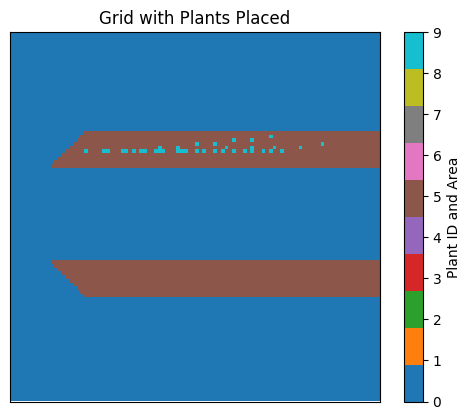

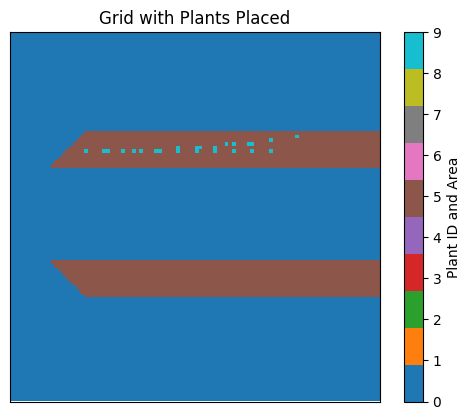

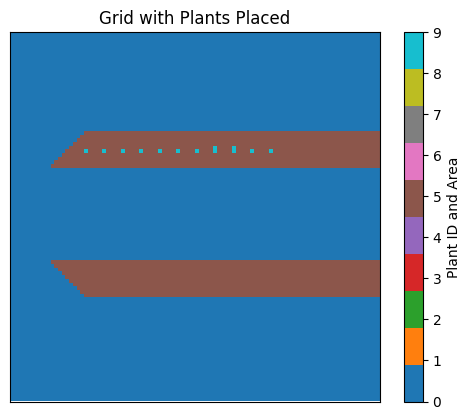

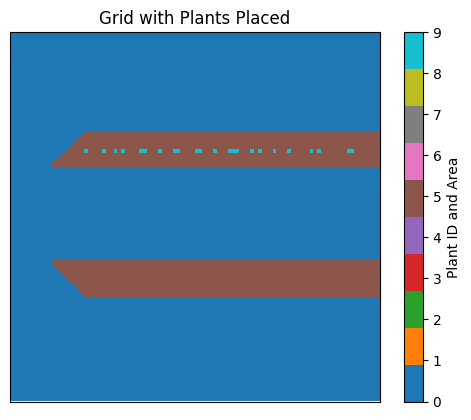

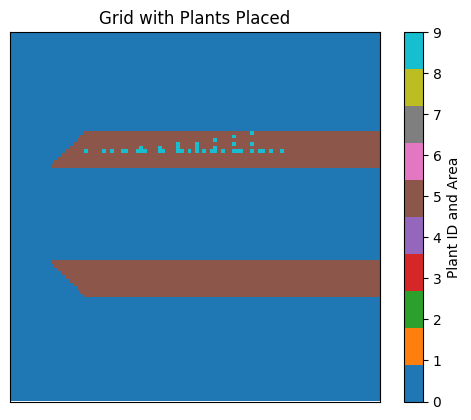

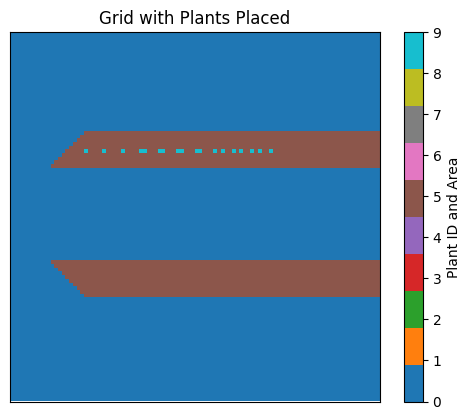

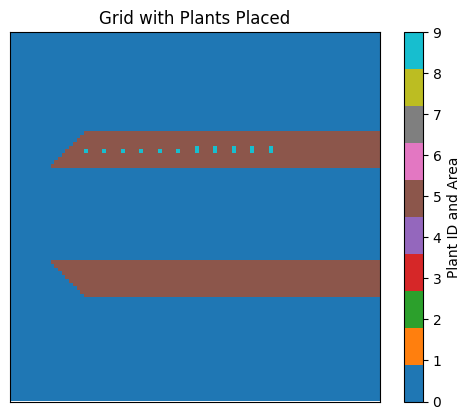

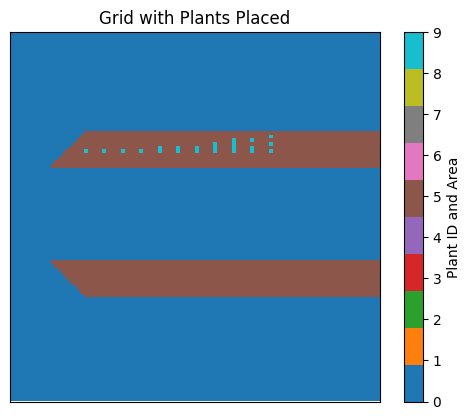

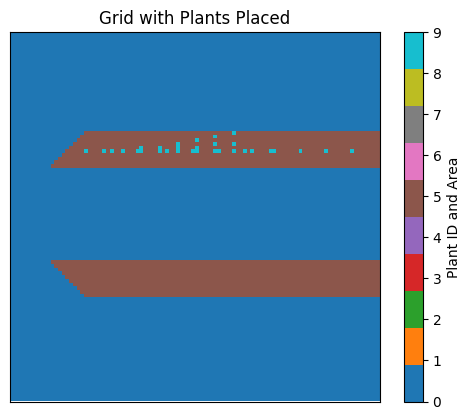

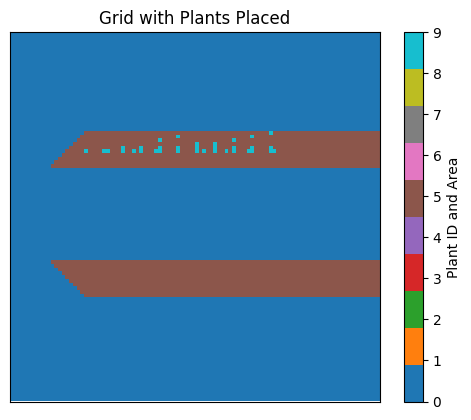

In [274]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from gymnasium import spaces, Env

class CustomGridEnv(Env):
    """Custom Grid environment with continuous action space for PPO."""
    
    def __init__(self, grid, point_to_place, max_angle, placed_grid):
        super(CustomGridEnv, self).__init__()
        
        self.grid_size = grid.shape[0]
        self.num_objects = 10  # Define the number of points to place based on your requirement
        
        self.grid = grid
        self.point_to_place = point_to_place
        self.max_angle = max_angle
        self.placed_grid = placed_grid
        
        # Continuous action space: A combination of the inputs used in the function (Box space)
        self.action_space = spaces.Box(low=np.array([1, 2, 0, 1]), high=np.array([101, 10, 45, 5]), dtype=np.float32)
        
        # Observation space: The grid, flattened
        self.observation_space = spaces.Box(low=0, high=9, shape=(self.grid_size * self.grid_size,), dtype=np.float32)
        
        self.seed_val = None  # To store seed if provided

    def reset(self, seed=None):
        """Resets the environment and returns the initial observation."""
        # Optional: Apply the seed for reproducibility
        if seed is not None:
            self.seed_val = seed
            np.random.seed(seed)
        
        self.grid = np.copy(self.placed_grid)  # Reset to the base grid with unplantable areas
        self.current_object = 0  # Track how many objects have been placed
        self.placed_positions = set()  # Keep track of placed positions
        return self.grid.flatten(), {}

    def step(self, action):
        """Takes an action by modifying inputs to the Collatz function and evaluates the reward."""
        start_x, steps, odd_angle_deflection, distance = action
        
        # Use the collatz function to generate points
        collatz_points = collatz_grid_visualize(start_x, int(steps), start_tile=self.point_to_place, 
                                                start_angle=self.max_angle, odd_angle_deflection=odd_angle_deflection, 
                                                distance=distance, visualize=False)
        
        reward = 0
        
        # Check if generated points fall within the correct areas and reward/penalize
        for point in collatz_points:
            if (0 <= point[0] < self.grid_size and 0 <= point[1] < self.grid_size) and \
               (self.placed_grid[point[0], point[1]] == self.placed_grid[self.point_to_place[0] + 1, self.point_to_place[1]]):
                reward += 1  # Reward for planting correctly
                self.grid[point[0], point[1]] = 9  # Mark the plant on the grid
            else:
                reward -= 1  # Penalize for planting in the wrong area

        done = self.current_object == len(collatz_points)
        terminated = done
        truncated = False

        return self.grid.flatten(), reward, terminated, truncated, {}

    def render(self):
        """Render the grid using matplotlib with the plants."""
        cmap = plt.cm.get_cmap("tab10", 10)  # Get a colormap with enough colors
        plt.imshow(self.grid, cmap=cmap, vmin=0, vmax=9)
        plt.title("Grid with Plants Placed")
        plt.xticks([])  # Remove x-axis labels
        plt.yticks([])  # Remove y-axis labels
        plt.grid(False)
        plt.colorbar(label="Plant ID and Area")
        plt.show()


def train_model(grid, point_to_place, max_angle, placed_grid):
    # Create an instance of the custom environment with all the required inputs
    env = CustomGridEnv(grid, point_to_place, max_angle, placed_grid)

    # Initialize PPO model (supports continuous action spaces)
    model = PPO("MlpPolicy", env, verbose=1)

    # Train the model
    model.learn(total_timesteps=50000)

    # Save the trained model
    model.save("ppo_grid_plant_placement_small")

    print("Training completed and model saved!")


def visualize_model(grid, point_to_place, max_angle, placed_grid):
    # Load the trained model
    model = PPO.load("ppo_grid_plant_placement")

    # Create an instance of the custom environment with all the required inputs
    env = CustomGridEnv(grid, point_to_place, max_angle, placed_grid)

    obs, _ = env.reset()

    for x in range(env.num_objects):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)

        # Render the current state of the grid
        if (x == env.num_objects - 1):
            env.render()

        if done:
            break


# Example Usage:
# Assuming the grid, point_to_place, max_angle, and placed_grid are defined
train_model(grid, point_to_place, max_angle, placed_grid)

for i in range(10):
    visualize_model(grid, point_to_place, max_angle, placed_grid)


## Testing on areas with different shapes

- Essentially this method allows for reducing in complexity to quadrants ig
- action space is changed to be scalable as it does not change in terms of size of the plot
- observable area still stays

- Allows for learning to be applied along same shapes in different orientation

C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\3012229466.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 2)  # Use 2 colors for feature and black


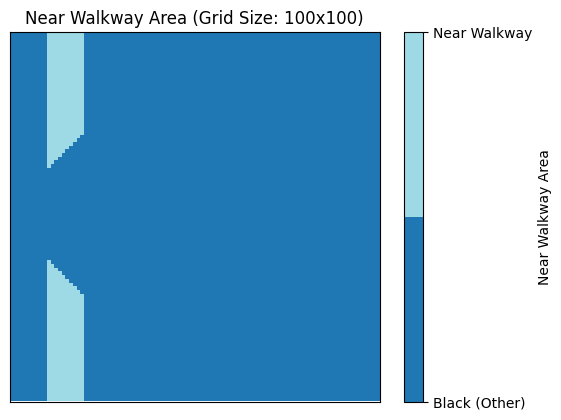

In [245]:
second_grid = render_specific_area(labeled_grid, feature_label=4, label_name="Near Walkway")


In [246]:
print(second_grid)

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


Distances from point (32, 20) to color change: [5, 4, 5, 79]


C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\3012229466.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 10)  # Use up to 10 colors to include the point


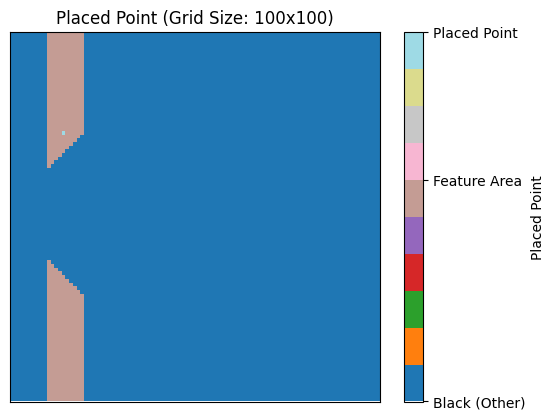

------------------------------
[27, 5, 4, 5]
90
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]
(27, 14)


In [247]:
point_to_place_2ND = (27, 14)  # Example tuple to place the point
second_grid_placed = place_point_on_grid(second_grid, point_to_place_2ND)

# Find distances to the nearest color change in all directions
distances_to_change_2ND, max_angle_2ND  = find_distance_and_max_angle(second_grid_placed, point_to_place_2ND, initial_color=4)
print(f"Distances from point {point_to_place} to color change: {distances_to_change}")

# Render the grid with the placed point
render_grid_with_point(second_grid_placed, point=point_to_place_2ND, point_color=9, label_name="Placed Point")


print('-' * 30)
print(distances_to_change_2ND)
print(max_angle_2ND)
print(second_grid_placed)
print(point_to_place_2ND)


C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\2689720629.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 7)  # 7 colors: 0 (empty), 1 (road), 2 (walkway), 3 (building), 4, 5, 6


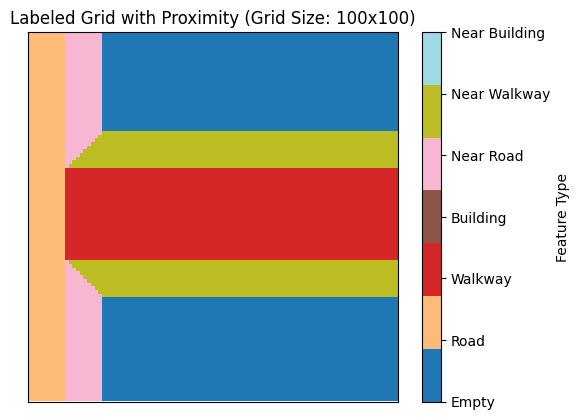

In [242]:
render_grid(grid)

In [276]:
def visualize_model(model, grid, point_to_place, max_angle, placed_grid):
    # Load the trained model
    model = PPO.load(model)

    # Create an instance of the custom environment with all the required inputs
    env = CustomGridEnv(grid, point_to_place, max_angle, placed_grid)

    obs, _ = env.reset()

    for x in range(env.num_objects):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)

        # Render the current state of the grid
        if (x == env.num_objects - 1):
            env.render()

        if done:
            break


C:\Users\yongl\AppData\Local\Temp\ipykernel_17460\1457612073.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)  # Get a colormap with enough colors


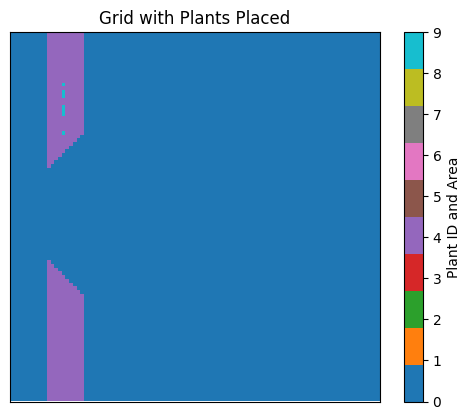

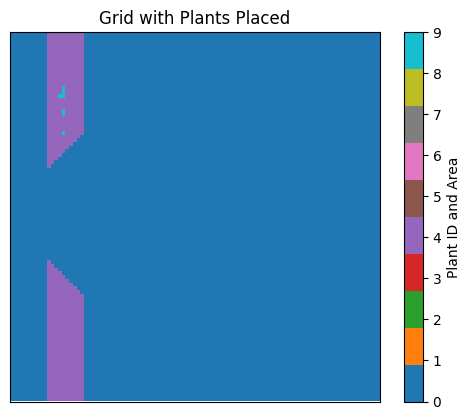

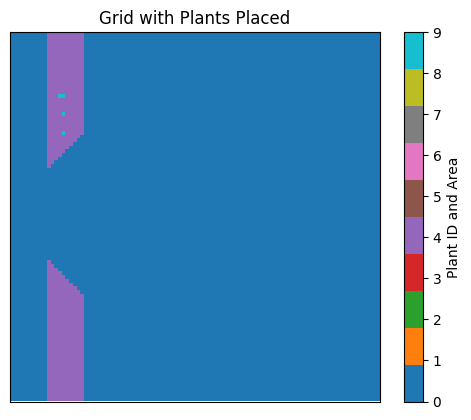

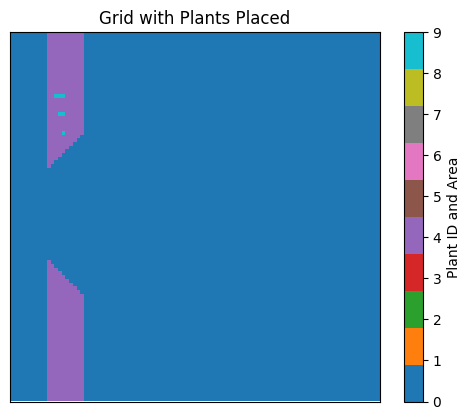

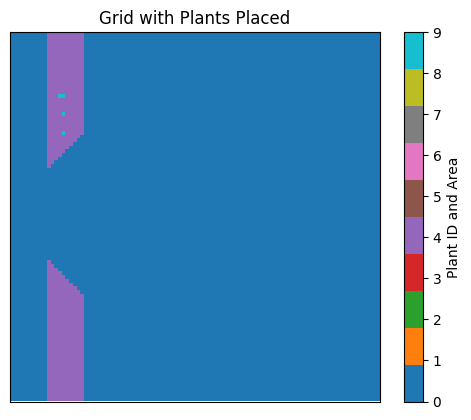

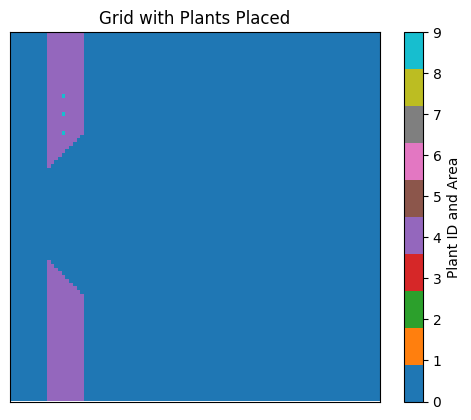

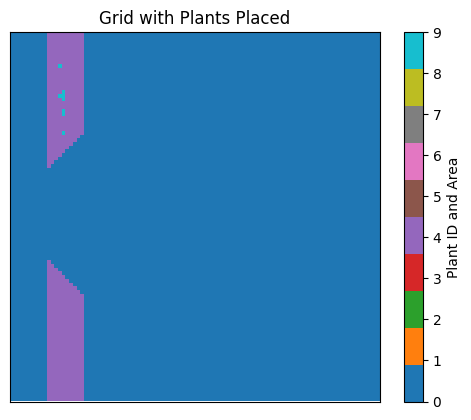

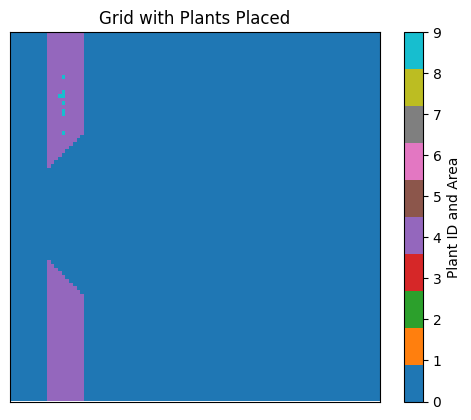

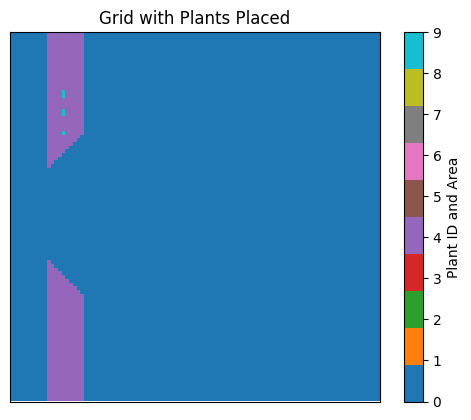

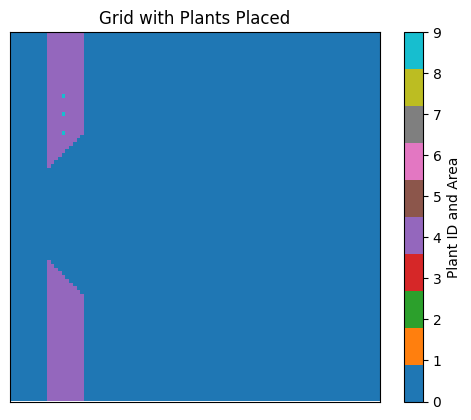

In [278]:
for i in range(10):
    visualize_model("ppo_grid_plant_placement", grid, point_to_place_2ND, max_angle_2ND, second_grid_placed)

## Next Steps

Allowing for plants to have radius lol

Training with different types of areas and see if the distance system is good enough to allow for angle change